<a href="https://colab.research.google.com/github/danielka223/ds_workshop/blob/master/dsWorkshopAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="left">Helpfulness Prediction of Amazon Product Reviews</h1> 
<h2 align="left">DS Workshop - Fall 18/19 - Tel Aviv University</h2> 
<h3 align="left">By Daniel K.A, Ido Salomon, Itamar Mutzafi and Sagi Aharoni</h3> 




#Notebook Initialization
This section should only run once on a new runtime

In [169]:
#@title Install Required Packages

!pip install wordcloud
!pip install nltk

In [0]:
#@title Import Python Libraries {display-mode: "form"}

import os
import glob
import pandas as pd
import csv
import json
import datetime
import random

from google.colab import drive

from contextlib import contextmanager
from os.path import getsize, basename
from tqdm import tqdm

import requests
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import gzip

from google.colab import files

import pickle

In [171]:
#@title Choose Data Source {display-mode: "form"}

def pickleRead(filename):
    data_f = open("drive/Team Drives/DS Workshop/pickled_vars/%s.pickle" % filename, "rb")
    data = pickle.load(data_f)
    data_f.close()
    return data

def pickleWrite(variable, filename):
    saveData = open("drive/Team Drives/DS Workshop/pickled_vars/%s.pickle" % filename, "wb")
    pickle.dump(variable, saveData)
    saveData.close()


data_source = 'Google Drive' #@param ["Google Drive", "Local Files", "Pickle"]
loaded_from_pickle = False

if (data_source == 'Google Drive'):
    # Connect to drive.
    drive.mount('/content/drive/')
elif (data_source == 'Local Files'):
    # Choose files manually.
    tsvFilesDirectory = "C:/Users/sagif/Desktop/Datascience/data/"
    numberOfReviewsInFile = 10
    
    ds_list = []
    for fileName in os.listdir(tsvFilesDirectory):
        if fileName.endswith(".tsv"):
            filePath = "".join((tsvFilesDirectory,fileName))
            cat_ds = pd.read_csv(filePath,
                encoding="utf8",
                delimiter='\t',
                warn_bad_lines=True,
                error_bad_lines=False,
                quoting=csv.QUOTE_NONE,
                nrows=numberOfReviewsInFile)
            ds_list.append(cat_ds)
    
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
    print("Done uploading files.")
elif (data_source == 'Pickle'):
  # Connect to drive.
  drive.mount('/content/drive/')
  #Load reviews from pickle.
  try:
    reviews = pickleRead("reviews")
    loaded_from_pickle = True
  except OSError:
      print("Error: Pickle variable may not exist. Try another data source.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#@title Infra Definitions

@contextmanager
def pbopen(filename, mode='r'):
    total = getsize(filename)
    pb = tqdm(total=total, unit="B", unit_scale=True,
              desc=basename(filename), miniters=1,
              ncols=80, ascii=True)

    def wrapped_line_iterator(fd):
        processed_bytes = 0
        for line in fd:
            processed_bytes += len(line)
            # update progress every MB.
            if processed_bytes >= 1024 * 1024:
                pb.update(processed_bytes)
                processed_bytes = 0

            yield line

        # finally
        pb.update(processed_bytes)
        pb.close()

    with open(filename, mode) as fd:
        yield wrapped_line_iterator(fd)
        
#decompress input folder to output folder
def ungzip(source_dir, dest_dir):
  for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
      base = os.path.basename(src_name)
      dest_name = os.path.join(dest_dir, base[:-3])
      with gzip.open(src_name, 'rb') as infile:
          with open(dest_name, 'wb') as outfile:
              for line in infile:
                  outfile.write(line)

In [0]:
#@title Data Fetching

# the following script downloads the Amazon Review Dataset into google drive

root = "drive/Team Drives/DS Workshop/data/"
compressed_path = root + "compressed/"

#uncomment to download
review_prefix = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/"
review_paths = [
#                 "amazon_reviews_us_Wireless_v1_00.tsv.gz"
#                 "amazon_reviews_us_Watches_v1_00.tsv.gz",
#                 "amazon_reviews_us_Video_Games_v1_00.tsv.gz",
#                 "amazon_reviews_us_Video_DVD_v1_00.tsv.gz",
#                 "amazon_reviews_us_Video_v1_00.tsv.gz",
#                 "amazon_reviews_us_Toys_v1_00.tsv.gz",
#                 "amazon_reviews_us_Tools_v1_00.tsv.gz",
#                 "amazon_reviews_us_Sports_v1_00.tsv.gz",
#                 "amazon_reviews_us_Software_v1_00.tsv.gz",
#                 "amazon_reviews_us_Shoes_v1_00.tsv.gz",
#                 "amazon_reviews_us_Pet_Products_v1_00.tsv.gz",
#                 "amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz",
#                 "amazon_reviews_us_PC_v1_00.tsv.gz",
#                 "amazon_reviews_us_Outdoors_v1_00.tsv.gz",
#                 "amazon_reviews_us_Office_Products_v1_00.tsv.gz",
#                 "amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz",
#                 "amazon_reviews_us_Music_v1_00.tsv.gz",
#                 "amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz",
#                 "amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz",
#                 "amazon_reviews_us_Major_Appliances_v1_00.tsv.gz",
#                 "amazon_reviews_us_Luggage_v1_00.tsv.gz",
#                 "amazon_reviews_us_Lawn_and_Garden_v1_00.tsv.gz",
#                 "amazon_reviews_us_Kitchen_v1_00.tsv.gz",
#                 "amazon_reviews_us_Jewelry_v1_00.tsv.gz",
#                 "amazon_reviews_us_Home_Improvement_v1_00.tsv.gz",
#                 "amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz",
#                 "amazon_reviews_us_Home_v1_00.tsv.gz",
#                 "amazon_reviews_us_Health_Personal_Care_v1_00.tsv.gz",
#                 "amazon_reviews_us_Grocery_v1_00.tsv.gz",
#                 "amazon_reviews_us_Gift_Card_v1_00.tsv.gz",
#                 "amazon_reviews_us_Furniture_v1_00.tsv.gz",
#                 "amazon_reviews_us_Electronics_v1_00.tsv.gz",
#                 "amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz",
#                 "amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz",
#                 "amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
#                 "amazon_rfeviews_us_Digital_Music_Purchase_v1_00.tsv.gz",
#                 "amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz",
#                 "amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv.gz",
#                 "amazon_reviews_us_Camera_v1_00.tsv.gz",
#                 "amazon_reviews_us_Books_v1_02.tsv.gz",
#                 "amazon_reviews_us_Books_v1_01.tsv.gz",
#                 "amazon_reviews_us_Books_v1_00.tsv.gz",
#                 "amazon_reviews_us_Beauty_v1_00.tsv.gz",
#                 "amazon_reviews_us_Baby_v1_00.tsv.gz",
#                 "amazon_reviews_us_Automotive_v1_00.tsv.gz",
#                 "amazon_reviews_us_Apparel_v1_00.tsv.gz",
               ]

#download dataset for each category, store in drive
for reviewName in review_paths:
  url = "".join((review_prefix, reviewName))
  print("started downloading " + url)
  category = re.search('us_(.+?)_v1', url).group(1)
  file_path = compressed_path + category + ".tsv.gz"
  r = requests.get(url, allow_redirects=True)
  open(file_path, 'wb').write(r.content)
  print("finished downloading " + url)

#unzip datasets  
#ungzip(compressed_path, root)

# Data Collection and Integration


##Load Data

In [0]:
include_all_categories = False #@param {type:"boolean"}
correct_bias = False #@param {type:"boolean"}
pick_category = "Wireless"  #@param ['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Books_v1_00', 'Books_v1_01', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Ebook_Purchase1', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift_Card', 'Grocery', 'Health_Personal_Care', 'Home', 'Home_Entertainment', 'Home_Improvement', 'Jewelry', 'Kitchen', 'Lawn_and_Garden', 'Luggage', 'Major_Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical_Instruments', 'Office_Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet_Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video_DVD', 'Video_Games', 'Watches', 'Wireless']
entry_limit = 1000000  #@param {type: "slider", min: 1000, max: 5000000, step:1000}
#@markdown ---
#@markdown ###Review Filters
min_date = '2013-01-01'  #@param {type: "date"}
max_date = '2019-01-01'  #@param {type: "date"}
is_random_entries = True #@param {type:"boolean"}

#generate ds paths
root = "drive/Team Drives/DS Workshop/data/"
file_ext = ".tsv"
ds_path = root + pick_category + file_ext

file_names = glob.glob1(root, "*" + file_ext)
all_paths = [root + filename for filename in file_names]

tsv_rows_no_dict = {'drive/Team Drives/DS Workshop/data/Wireless.tsv': 9002021, 'drive/Team Drives/DS Workshop/data/Video_DVD.tsv': 5069140, 'drive/Team Drives/DS Workshop/data/Video.tsv': 380604, 'drive/Team Drives/DS Workshop/data/Toys.tsv': 4864249, 'drive/Team Drives/DS Workshop/data/Tools.tsv': 1741100, 'drive/Team Drives/DS Workshop/data/Sports.tsv': 4850360, 'drive/Team Drives/DS Workshop/data/Software.tsv': 341931, 'drive/Team Drives/DS Workshop/data/Shoes.tsv': 4366916, 'drive/Team Drives/DS Workshop/data/Pet_Products.tsv': 2643619, 'drive/Team Drives/DS Workshop/data/Personal_Care_Appliances.tsv': 85981, 'drive/Team Drives/DS Workshop/data/PC.tsv': 6908554, 'drive/Team Drives/DS Workshop/data/Outdoors.tsv': 2302401, 'drive/Team Drives/DS Workshop/data/Office_Products.tsv': 2642434, 'drive/Team Drives/DS Workshop/data/Musical_Instruments.tsv': 904765, 'drive/Team Drives/DS Workshop/data/Music.tsv': 4751577, 'drive/Team Drives/DS Workshop/data/Mobile_Electronics.tsv': 104975, 'drive/Team Drives/DS Workshop/data/Mobile_Apps.tsv': 5033376, 'drive/Team Drives/DS Workshop/data/Major_Appliances.tsv': 96901, 'drive/Team Drives/DS Workshop/data/Luggage.tsv': 348657, 'drive/Team Drives/DS Workshop/data/Lawn_and_Garden.tsv': 2557288, 'drive/Team Drives/DS Workshop/data/Kitchen.tsv': 4880466, 'drive/Team Drives/DS Workshop/data/Jewelry.tsv': 1767753, 'drive/Team Drives/DS Workshop/data/Home_Improvement.tsv': 2634781, 'drive/Team Drives/DS Workshop/data/Home_Entertainment.tsv': 705889, 'drive/Team Drives/DS Workshop/data/Home.tsv': 6221559, 'drive/Team Drives/DS Workshop/data/Health_Personal_Care.tsv': 5331449, 'drive/Team Drives/DS Workshop/data/Grocery.tsv': 2402458, 'drive/Team Drives/DS Workshop/data/Gift_Card.tsv': 149086, 'drive/Team Drives/DS Workshop/data/Furniture.tsv': 792113, 'drive/Team Drives/DS Workshop/data/Electronics.tsv': 3093869, 'drive/Team Drives/DS Workshop/data/Digital_Video_Download.tsv': 4057147, 'drive/Team Drives/DS Workshop/data/Digital_Software.tsv': 102084, 'drive/Team Drives/DS Workshop/data/Digital_Music_Purchase.tsv': 1688884, 'drive/Team Drives/DS Workshop/data/Digital_Ebook_Purchase1.tsv': 12520722, 'drive/Team Drives/DS Workshop/data/Camera.tsv': 1801974, 'drive/Team Drives/DS Workshop/data/Books.tsv': 3105520, 'drive/Team Drives/DS Workshop/data/Digital_Ebook_Purchase.tsv': 5101693, 'drive/Team Drives/DS Workshop/data/Books_v1_01.tsv': 6106719, 'drive/Team Drives/DS Workshop/data/Books_v1_00.tsv': 10319090, 'drive/Team Drives/DS Workshop/data/Beauty.tsv': 5115666, 'drive/Team Drives/DS Workshop/data/Baby.tsv': 1752932, 'drive/Team Drives/DS Workshop/data/Automotive.tsv': 3514942, 'drive/Team Drives/DS Workshop/data/Apparel.tsv': 5906333, 'drive/Team Drives/DS Workshop/data/Watches.tsv': 960872, 'drive/Team Drives/DS Workshop/data/Video_Games.tsv': 1785997, 'drive/Team Drives/DS Workshop/data/Digital_Video_Games.tsv': 145431}

In [175]:
if include_all_categories:
  selected_paths = all_paths
else:
  selected_paths = [ds_path]
  
ds_list = []

if (not loaded_from_pickle):
  if (data_source == 'Google Drive'):
    for path in selected_paths:
      print("loading: ", path)
      print()
      if is_random_entries:
        skip = random.sample(range(1, tsv_rows_no_dict[path]), tsv_rows_no_dict[path] - entry_limit//len(selected_paths))
      else:
        skip = []
      cat_ds = pd.read_csv(path, 
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          skiprows = skip,
                          quoting=csv.QUOTE_NONE,
                          encoding="utf8",
                          #skiprows=range(1,100)#skiprows=skip,
                          nrows=entry_limit//len(selected_paths))
      ds_list.append(cat_ds)
    reviews = pd.concat(ds_list, axis = 0, ignore_index = True)
  elif (data_source == 'Local Files'):
    reviews = pd.read_csv(ds_path, 
                          encoding="utf8",
                          delimiter='\t',
                          warn_bad_lines=True,
                          error_bad_lines=False,
                          quoting=csv.QUOTE_NONE,
                          nrows=entry_limit)

reviews = reviews[reviews['review_date'] > min_date]
reviews = reviews[reviews['review_date'] < max_date]

loading:  drive/Team Drives/DS Workshop/data/Wireless.tsv



##Data Overview

In [176]:
print('Description: \n')
print(reviews.describe())
print('Data types: \n')
print(reviews.dtypes)
display(reviews.head())
display(reviews.tail())

Description: 

        customer_id  product_parent    star_rating  helpful_votes  \
count  8.428120e+05    8.428120e+05  842812.000000  842812.000000   
mean   2.451828e+07    5.022146e+08       3.922426       0.625805   
std    1.596023e+07    2.881200e+08       1.455259       7.932920   
min    1.009800e+04    4.101000e+03       1.000000       0.000000   
25%    1.126981e+07    2.544920e+08       3.000000       0.000000   
50%    2.223746e+07    5.024754e+08       5.000000       0.000000   
75%    3.944208e+07    7.504092e+08       5.000000       0.000000   
max    5.309650e+07    9.999957e+08       5.000000    3378.000000   

         total_votes  
count  842812.000000  
mean        0.847571  
std         8.673598  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max      3468.000000  
Data types: 

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
pr

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,13334021,R11LOHEDYJALTN,B00XVGJMDQ,421688488,"iPhone 6 Case, Vofolen Impact Resistant Protec...",Wireless,5,0,0,N,Y,Five Stars,"Great Case, better customer service!",2015-08-31
1,US,15867807,R1DJ8976WPWVZU,B00HX3G6J6,299654876,"HTC One M8 Screen Protector, Skinomi TechSkin ...",Wireless,3,0,0,N,Y,seems durable but these are always harder to g...,seems durable but these are always harder to g...,2015-08-31
2,US,17552454,R2EZXET9KBFFU3,B00KDZEE68,148320945,zBoost ZB575-A TRIO SOHO Tri Band AT&T 4G Cell...,Wireless,1,0,0,N,Y,One Star,you have to turn power off to this unit once o...,2015-08-31
3,US,4811414,R3SPEGYBROLSP1,B00QQTFYAA,194128090,"S5 Cable, Galaxy S5 Cable - Charging Sync Cabl...",Wireless,1,1,1,N,Y,One Star,This cord didn't work at all,2015-08-31
4,US,2873589,R34KV4IES8WA1N,B00ZBGVBOC,414657030,BestElec Micro Bundle 3-in-1 Economy Home and ...,Wireless,1,0,0,N,Y,One Star,The car plug in broke within a week of using it.,2015-08-31


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
842807,US,43349842,R3MDA1OMPLHNDL,B0091LGPMQ,467715869,Eagle Cell Barely There Slim and Soft Skin Cas...,Wireless,5,0,0,N,Y,Soft skin iPhone 5 case,I like the non slip characteristic of this cas...,2013-01-02
842808,US,29426900,RUF53XPDUWVGD,B006382XAS,249808984,Stand with Mini Tripod Mount Adapter for iPhon...,Wireless,5,0,0,N,Y,Sam product for much less.,Make sure you get a nice thick rubber band to ...,2013-01-02
842809,US,15042302,R2KLC5HENQEWB3,B0085WZEA6,298557054,Fosmon Rapid Micro USB Car Charger + Home Micr...,Wireless,5,0,0,N,Y,Does the job with no problems,These work just fine for my new Samsung Galaxy...,2013-01-02
842810,US,45014678,R2NMKJUETMSK5U,B0050A35YI,698111998,Electromaster(TM) Brand - Purple Bumper Silico...,Wireless,4,0,0,N,N,Bumper,It's great for a bumper. Love the color and si...,2013-01-02
842811,US,11697701,R6IEAM224NXK4,B004DC2LQC,525874633,Cbus Wireless Black & White Flower Snap On Har...,Wireless,1,0,0,N,Y,This Half of case,This cell phone case was half of a case also o...,2013-01-02


#Data Preperation and Cleaning

In [0]:
#Cleanup in review text: <br>,<br/>,&#34;, [[...]]
reviews['review_body'] = reviews['review_body'].replace('\[\[.*\]\]|<.*br.*>',' ',regex=True)
reviews['review_body'] = reviews['review_body'].replace('&#34;|[^\x00-\x7F]+','',regex=True)

#Data Visualization and Analysis

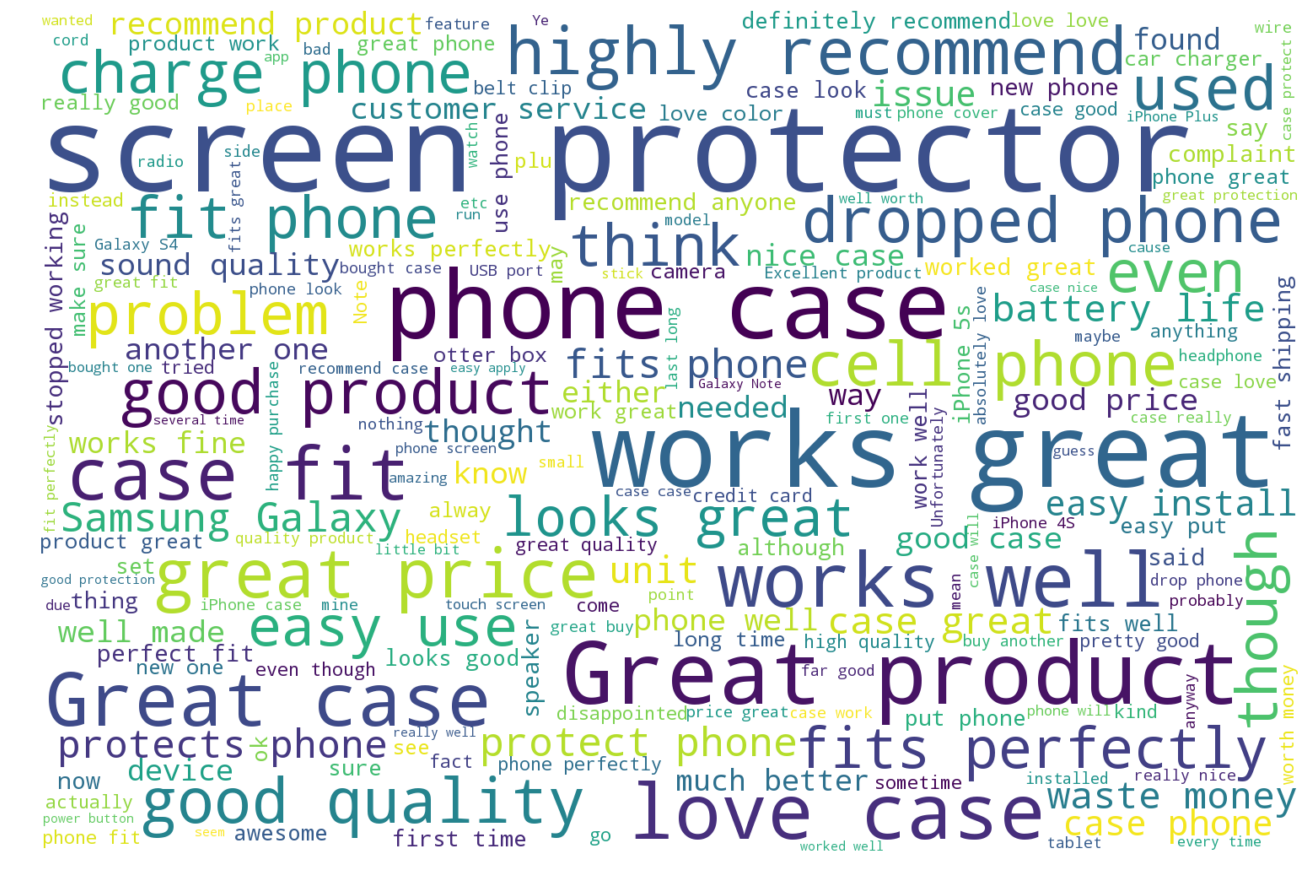

In [178]:
#wordcloud
text = reviews['review_body'].values #returns a list of review texts
text = ' '.join(str(rev) for rev in text) #returns a huge string containing all reviews one by one
assert('review_body' not in text)

wordcloud = WordCloud(
    width = 1500,
    height = 1000,
    background_color = 'white',
    ).generate(text)
fig = plt.figure(
    figsize = (18, 12),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud = []

# Feature Selection and Engineering

In [179]:
def add_meta_features(dataset):
  dataset['helpful'] = ApplyHelpfulnessVector(dataset) 
  
def ApplyHelpfulnessVector(reviews):
  return reviews.apply(lambda row: isHelpful(row['total_votes'], row['helpful_votes']), axis=1)
  
def isHelpful(total_votes, helpful_votes):
  if (total_votes >=4 and helpful_votes > total_votes - helpful_votes):
      return 1
  elif (total_votes < 4):
      return 0
  else:
      return -1

if (not loaded_from_pickle):
  add_meta_features(reviews)
  # Add no. of helpful comments for each reviewer
  commentCount=pd.DataFrame(reviews.groupby('customer_id').size())
  commentCount.columns=['commentCount']
  reviews = reviews.join(commentCount, on='customer_id')
  helpfulRatingPerUser = pd.DataFrame(reviews.groupby('customer_id').sum())
  helpfulRatingPerUser = helpfulRatingPerUser.drop(columns=['product_parent','star_rating','helpful_votes','total_votes','commentCount'])
  helpfulRatingPerUser.columns=['userHelpfulness']
  reviews = reviews.join(helpfulRatingPerUser, on='customer_id')
  reviews['userHelpfulness'] = reviews['userHelpfulness'] - reviews['helpful']
  
reviews.describe() #debug

,customer_id,product_parent,star_rating,helpful_votes,total_votes,helpful,commentCount,userHelpfulness
count,8.428120e+05,8.428120e+05,842812.000000,842812.000000,842812.000000,842812.000000,842812.000000,842812.000000
mean,2.451828e+07,5.022146e+08,3.922426,0.625805,0.847571,0.023366,1.350415,0.020508
std,1.596023e+07,2.881200e+08,1.455259,7.932920,8.673598,0.203716,1.508714,0.363218
min,1.009800e+04,4.101000e+03,1.000000,0.000000,0.000000,-1.000000,1.000000,-4.000000
25%,1.126981e+07,2.544920e+08,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.223746e+07,5.024754e+08,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.944208e+07,7.504092e+08,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.309650e+07,9.999957e+08,5.000000,3378.000000,3468.000000,1.000000,61.000000,17.000000


## Bias Correction

In [180]:
model_input_entry_limit = 10000  #@param {type: "slider", min: 1000, max: 1000000, step:100}

print("[IN] biased reviews: ", reviews.count()[0])

if (not loaded_from_pickle):
  df1 = reviews[reviews['helpful'] == -1]
  df2 = reviews[reviews['helpful'] == 1]
  if correct_bias:
    df2 = reviews[reviews['helpful'] == 1].sample(n=df1.count()[0])
  reviews = pd.concat([df1,df2])

  print("helpful reviews: ", reviews[reviews['helpful'] == 1].count()[0])
  print("neutral reviews: ", reviews[reviews['helpful'] == 0].count()[0])
  print("unhelpful reviews: ", reviews[reviews['helpful'] == -1].count()[0])
  print("[OUT] unbiased reviews: ", reviews.count()[0])
  
  assert reviews.shape[0] > model_input_entry_limit, str("Error: expecting %d entries, however only %d are available" % (model_input_entry_limit, reviews.shape[0]))
  reviews = reviews.sample(n=model_input_entry_limit)
  print("[MODEL_INPUT] unbiased reviews: ", reviews.count()[0])

[IN] biased reviews:  842812
helpful reviews:  27565
neutral reviews:  0
unhelpful reviews:  7872
[OUT] unbiased reviews:  35437
[MODEL_INPUT] unbiased reviews:  10000


In [181]:
#@markdown ###Save reviews locally for quick loading?
save_reviews = False #@param {type:"boolean"}

if (save_reviews):
  pickleWrite(reviews, "reviews")
  print("Reviews were saved")

reviews.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,helpful,commentCount,userHelpfulness
665046,US,22022327,RY3ROTVIA9OV4,B002KO5XVU,948786846,Ram Mount 2.43 x 1.31-Inch Diamond Ball Base w...,Wireless,5,3,4,N,Y,"RAM -B-238 2.43""x1.31"" dimamond base with 1"" ball",I bought this RAM B-238 2.43 x 1.31 diamond b...,2013-12-03,1,2,0
822961,US,23844060,R1SDS42EVWHHHN,B00AB7FVCY,544535202,Samsung Galaxy Note II 16GB 4G LTE Android - V...,Wireless,5,8,9,N,N,Note 1 Legacy to Note II,I have the Note I and wanted to mention someth...,2013-02-02,1,1,0
831221,US,11397400,R3DZY0KOH9AU9C,B008KYY0ZE,402765038,Garmin Approach S1 GPS Golf Watch,Wireless,1,4,6,N,Y,Inaccurate...,"Has to return, as accuracy simply wasn't there...",2013-01-19,1,2,0
500926,US,51189409,R18L8M8IYUJ8X4,B00INMMLI6,380229256,Touch Screen Glass Digitizer for LG G2 D800 D8...,Wireless,1,2,5,N,N,Order only after you take the phone apart.,"This part is great, but only if you can take t...",2014-08-04,-1,3,0
824764,US,44986635,R31EWXZ6ZWXZY,B00A7DM0D0,301651738,HTC One X+ (AT&T),Wireless,1,4,23,N,N,"power sucks, Dropbox free space is a joke for ...",This review previously was submitted on HTC of...,2013-01-30,-1,1,0


# Model Training

In [0]:
# # CNN for the IMDB problem
# import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Convolution1D, Flatten, Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing.sequence import pad_sequences
# import re
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import pickle
# from keras.utils import np_utils
# import pandas as pd
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from keras.wrappers.scikit_learn import KerasClassifier


# data = reviews
# data = data.loc[:, ['review_body','helpful']]


# #Convert reviews text to lowercase
# data['text'] = data['review_body'].apply(lambda x: str(x).lower())
# #Remove all charactares appart from a-zA-z0-9 (for instance: punctuation)
# data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# #overallDistribution = data.overall.value_counts().sort_index()
# #print(overallDistribution)

# #Vocabulary size - Most 2000 common words
# #Convert input text to integer sequences
# max_features = 5000
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(data['text'].values)
# X = tokenizer.texts_to_sequences(data['text'].values)
# #cap the maximum review length at 500 words,
# #truncating reviews longer than that and
# # padding reviews shorter than that with 0 values.
# max_review_length = 500
# X = pad_sequences(X,  maxlen=max_review_length)

# # Using embedding from Keras
# embedding_vector_length = 32
# def baseline_model():
#     # create the model - Machine learning mastery
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
#     model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     # model.add(Dropout(0.1))
#     model.add(Dense(250, activation='relu'))
#     # model.add(Dense(1, activation='sigmoid'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
#     return model

# Y = data['helpful']
# # Fit the model
# epochs_num = 2
# batchSize = 128

# model = KerasClassifier(build_fn=baseline_model, epochs=epochs_num, batch_size=batchSize, verbose=0)

# nsplits = 3
# kfold = KFold(n_splits=nsplits, shuffle=True, random_state=1)
# results = cross_val_score(model, X, Y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#Non DL Models

In [183]:
from __future__ import print_function
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import nltk
import string
from sklearn.model_selection import cross_validate

#@markdown ###Pipeline Options
selectKBest_k_value = 5000  #@param {type: "slider", min: 1000, max: 50000, step:1000}

nltk.download('stopwords')
nltk.download('wordnet')

data = reviews
data = data.loc[:, ['review_body','helpful']]

X = data['review_body'].astype('U')
Y = data['helpful']

print(X.size)
print(Y.size)
print(stopwords.words('english'))

def stemTokenizer(sentence):
    ret = RegexpTokenizer('[a-zA-Z0-9\']+')
    sw = set(stopwords.words('english'))
    tokens= ret.tokenize(sentence)
    ess = SnowballStemmer('english', ignore_stopwords=True)
    return [ess.stem(t) for t in tokens if t not in sw]

def lemmaTokenizer(sentence):
    ret = RegexpTokenizer('[a-zA-Z0-9\']+')
    sw = set(stopwords.words('english'))
    tokens= ret.tokenize(sentence)
    wnl = WordNetLemmatizer()

    #return [wnl.lemmatize(t) for t in tokens if t not in sw]
    return [wnl.lemmatize(t) for t in tokens]

  
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text)}  for text in posts]

class Debug(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, posts):
        print(posts)
        return self

pipeline = Pipeline([
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for standard bag-of-words model for body
            ('body_bow', Pipeline([
                ('vect', CountVectorizer(tokenizer = stemTokenizer, 
                          ngram_range=(1, 2),
                          binary = True, min_df=2, max_df=0.8)),
                          ('tfidf', TfidfTransformer()),
                
            ])),
            
            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
        ],
        # weight components in FeatureUnion
        transformer_weights={
            'body_bow': 0.85,
            'body_stats': 0.15,
        },
    )),
    ('chi2', SelectKBest(chi2, k=selectKBest_k_value)), #5000
    # Use a SVC classifier on the combined features
    #('clf', SGDClassifier( penalty='elasticnet')),
    #('clf', MultinomialNB(fit_prior=False)),
    #('clf', LogisticRegression()),
    ('clf', RandomForestClassifier(n_estimators=100))
])

#pipeline.fit(X, Y)

from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

scoring = {'acc':'accuracy',
           'f1':'f1', 
           'prec':'precision', 
           'rec':'recall',
           'roc': 'roc_auc',
           'tp' : make_scorer(tp),
           'tn' : make_scorer(tn),
           'fp' : make_scorer(fp),
           'fn' : make_scorer(fn)
          }

nsplits = 3
kfold = KFold(n_splits=nsplits, shuffle=True, random_state=1)
results = cross_validate(pipeline, X, Y, cv=kfold, scoring=scoring)
print(results)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

{'fit_time': array([14.22, 12.81, 13.16]), 'score_time': array([32.7 , 32.32, 31.76]), 'test_acc': array([0.66, 0.66, 0.66]), 'train_acc': array([1., 1., 1.]), 'test_f1': array([0.65, 0.65, 0.65]), 'train_f1': array([1., 1., 1.]), 'test_prec': array([0.66, 0.68, 0.66]), 'train_prec': array([1., 1., 1.]), 'test_rec': array([0.64, 0.64, 0.64]), 'train_rec': array([1.  , 1.  , 0.99]), 'test_roc': array([0.71, 0.71, 0.72]), 'train_roc': array([1., 1., 1.]), 'test_tp': array([1146, 1113, 1124]), 'train_tp': array([3306, 3354, 3315]), 'test_tn': array([1050, 1081, 1065]), 'train_tn': array([3346, 3302, 3334]), 'test_fp': array([600, 620, 594]), 'train_fp': array([14,  7, 17]), 'test_fn': array([538, 519, 550]), 'train_fn': array([0, 4, 1])}
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
10000
10000
['i', 'me

##Flow Understanding


In [0]:


# cnt_vectorizer = CountVectorizer(tokenizer = lemmaTokenizer,
                                         
#                                 ngram_range=(1, 2),
#                                 binary = True, min_df=2, max_df=0.8)

# X1 = cnt_vectorizer.fit_transform(X)
# print(cnt_vectorizer.get_feature_names())
# print(X1.toarray())  
# print(X1.shape)

# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X1)
# # print(X_train_tfidf)
# print(X_train_tfidf.shape)
# print(X_train_tfidf[0])
# dict={}
# for doc in X_train_tfidf:
#   x=3
# dict[44]=33
# # print(dict)
# print(X_train_tfidf[0][0])

## debug

In [185]:
# from sklearn.model_selection import cross_val_predict
# y_pred = cross_val_predict(pipeline, X, Y, cv=kfold)
# # cnf_matrix = confusion_matrix(Y, y_pred)

# ones = Y[y_pred == 1]
# minus = Y[y_pred == -1]

# print(ones[ones == 1].size) # tp
# # print(ones[ones == -1].size) # fp

# print(minus[minus == -1].size) # tn
# # print(minus[minus == 1].size) # fn

conf_mat = [[sum(results['test_tn']), sum(results['test_fp'])],
            [sum(results['test_fn']), sum(results['test_tp'])]]
conf_mat = np.array(conf_mat)
print(conf_mat)

[[7509  195]
 [1976  320]]


# Model Evaluation

## Results

## Plot Confusion Matrix

Confusion matrix, without normalization
[[7509  195]
 [1976  320]]
Normalized confusion matrix
[[0.97 0.03]
 [0.86 0.14]]


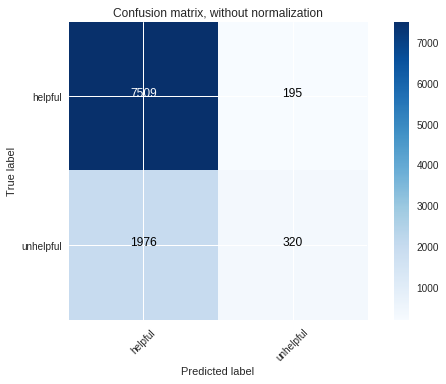

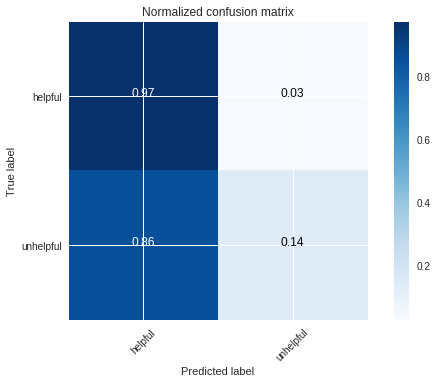

In [186]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['helpful','unhelpful'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['helpful','unhelpful'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()